In [134]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

#Assume installed from github using "git clone --recursive https://github.com/cmbant/CAMB.git"
#This file is then in the docs folders
camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))
import math 
import time

Using CAMB 1.3.6 installed at /Users/junalexsugiyama/opt/anaconda3/envs/camb/lib/python3.9/site-packages/camb


# Problem 1

In [135]:
data_bin = np.loadtxt("/Users/junalexsugiyama/Desktop/PHYS512/repo/phys512-2022/problem_sets/mcmc/COM_PowerSpect_CMB-TT-binned_R3.01.txt")
data_full = np.loadtxt("/Users/junalexsugiyama/Desktop/PHYS512/repo/phys512-2022/problem_sets/mcmc/COM_PowerSpect_CMB-TT-full_R3.01.txt")

chisq is  15267.937968222595  for  2505  degrees of freedom.


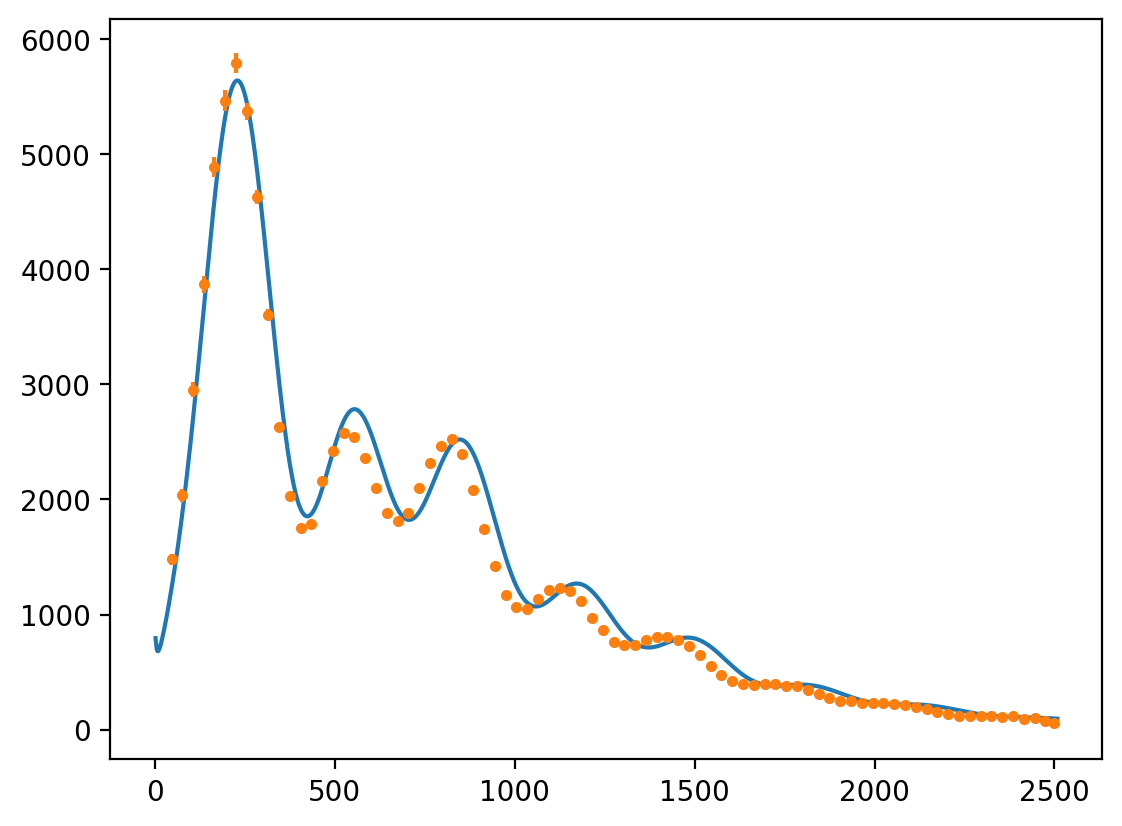

chisq is  3272.2033778089576  for  2505  degrees of freedom.


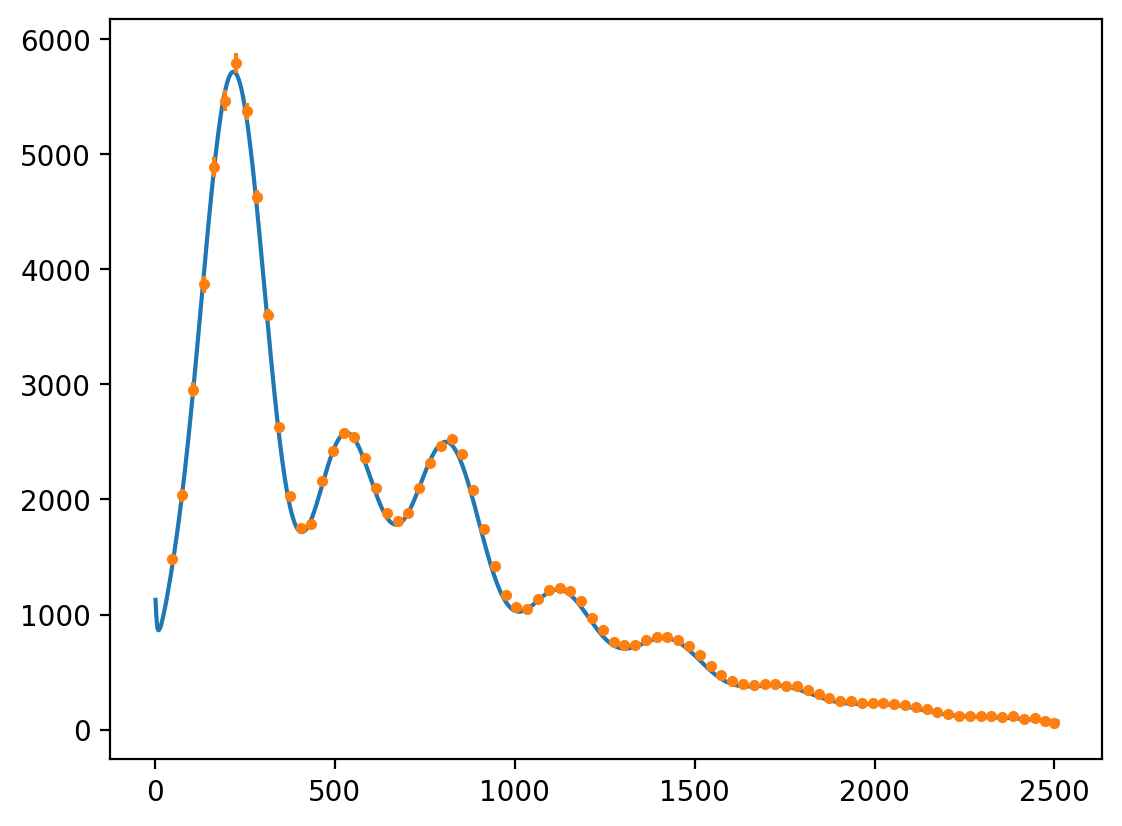

In [136]:
# copy of the Sievers code, file: planck_likelyhood.py
# changed code to make the program run twice. 

def get_spectrum(pars,lmax=3000):
    #print('pars are ',pars)
    #print('parameters:', pars)
    #print('shpae of pars',np.shape(pars))
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]   
    
    return tt[2:]


plt.ion()

pars=np.asarray([[60,0.02,0.1,0.05,2.00e-9,1.0], [69, 0.022, 0.12, 0.06, 2.1e-9, 0.95]])
planck=data_full

for i in range(2):
    
    ell=planck[:,0]
    spec=planck[:,1]
    errs=0.5*(planck[:,2]+planck[:,3]);
    model=get_spectrum(pars[i])
    model=model[:len(spec)]
    resid=spec-model
    chisq=np.sum( (resid/errs)**2)
    print("chisq is ",chisq," for ",len(resid)-len(pars)," degrees of freedom.")
   
    planck_binned=data_bin

    
    errs_binned=0.5*(planck_binned[:,2]+planck_binned[:,3]);
    
    plt.plot(ell,model)
    plt.errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.')
    plt.show()

The first fitted parameters gave $\chi^2$ = 15267.937968222595 with $\langle \chi^2 \rangle = 2505$ and $\sigma_{\chi^2} = \sqrt{2 * 2505} = 70.781$.  The result is outside of $3\sigma$ threshhold -- not the best fit. 

The second fitted parameters gave $\chi^2$ = 3272.2033778089576 with the same $\langle \chi^2 \rangle  $ and $\sigma_{\chi^2}$ .  The result is outside of $3\sigma$ threshhold -- not the best fi, but better than the first one. 

# Problem 2

Data arangement : 
    
    1)multipole (starting with the l=2 quadrupole),
    
    2) the variance of the sky at that multipole, 
    
    3) the 1σ lower uncertainty
    
    4) the 1σ upper uncertainty.

In [259]:
pars=np.asarray([69, 0.025, 0.11, 0.06, 2.1e-9, 0.95])
B =  np.zeros(shape=(2507, len(pars)))

def deriv(func, m, params, A):
    args_0 = list(params)
    if params[2] == 0:
        ϵ = 1*10**(-9)
    else:
        ϵ = params[m]/100
   # if ϵ == 0:
    #    ϵ = 1*10**(-6)
    args_0[m] -= ϵ
    
    args_1 = list(params)
    args_1[m] += ϵ

    A[0:2507, m] = ((func(args_1) - func(args_0)) / (2*ϵ))[0:2507]
        
    return A

for i in range(len(pars)):
    deriv(get_spectrum,i ,pars, B)

In [246]:
N= np.eye(len(data_full[:, 2]))
np.fill_diagonal(N,((data_full[:, 2] + data_full[:, 3])/2))
Ninv = np.linalg.inv(N)

In [247]:
for i in range(5):
    model = get_spectrum(pars)[0:2507] 
    r = data_full[:, 1] - model
    err = (r**2).sum()
    r = np.matrix(r).transpose()
    grad = np.matrix(B)
    lhs = grad.transpose() @ Ninv @  grad
    
    rhs = grad.transpose() @ Ninv @ r
    
    dp = np.linalg.inv(lhs) @ rhs
    print('')
    for jj in range(pars.size):
        pars[jj] = pars[jj] + dp[jj]
print(pars, err)






[ 6.78957542e+01  2.22001402e-02  1.18231486e-01 -8.72958617e-02
  1.76573193e-09  9.70287646e-01] 108706199.66158609


chisq is  4451.143675261988  for  2501  degrees of freedom.


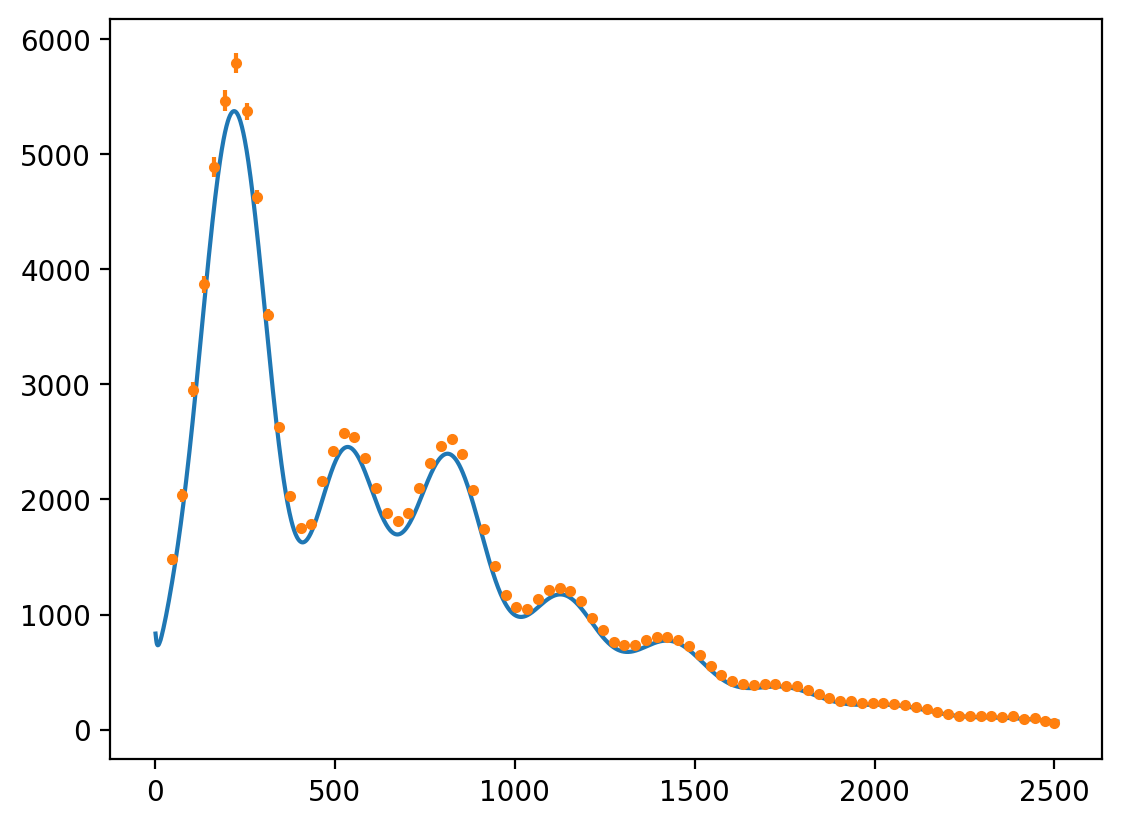

In [249]:
ell=planck[:,0]
spec=planck[:,1]
errs=0.5*(planck[:,2]+planck[:,3]);
model=get_spectrum(pars)
model=model[:len(spec)]
resid=spec-model
chisq=np.sum( (resid/errs)**2)
print("chisq is ",chisq," for ",len(resid)-len(pars)," degrees of freedom.")

planck_binned=data_bin


errs_binned=0.5*(planck_binned[:,2]+planck_binned[:,3]);

plt.plot(ell,model)
plt.errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.')
plt.show()

In [250]:
curve_mat = np.linalg.inv(lhs)
parameters = pars

In [251]:
file0 = open('planck_fit_params.txt', 'w')
file0.write(str(pars)) # parameters found via newton method
file0.write( str(np.sqrt(np.diag(curve_mat)))) # errors
file0.close()

## Bonus 

In [264]:
pars_nodm = np.asarray([68, 0.025, 0, 0.06, 2.1e-9, 0.95])


In [265]:
B =  np.zeros(shape=(2507, len(d_mat_zero)))
for i in range(len(pars_nodm)):
    deriv(get_spectrum,i ,pars_nodm, B)
for i in range(5):
    model = get_spectrum(pars_nodm)[0:2507] 
    r = data_full[:, 1] - model
    err = (r**2).sum()
    r = np.matrix(r).transpose()
    grad = np.matrix(B)
    lhs = grad.transpose() @ Ninv @  grad
    
    rhs = grad.transpose() @ Ninv @ r
    
    dp = np.linalg.inv(lhs) @ rhs
    print('')
    for jj in range(pars_nodm.size):
        pars_nodm[jj] = pars[jj] + dp[jj]
    
print('Parameters with no dark matter:', pars_nodm)

curve_mat_nodm = np.linalg.inv(lhs)






Parameters with no dark matter: [ 6.67027503e+01  2.63400108e-02  1.10219408e-01 -7.74943202e-02
  1.49870138e-09  9.63816095e-01]


In [266]:
ell=planck[:,0]
spec=planck[:,1]
errs=0.5*(planck[:,2]+planck[:,3]);
model=get_spectrum(pars_nodm)
model=model[:len(spec)]
resid=spec-model
chisq=np.sum( (resid/errs)**2)
print("chisq is ",chisq," for ",len(resid)-len(pars)," degrees of freedom.")

chisq is  20521.248407584902  for  2501  degrees of freedom.


In [267]:
file_b = open('planck_fit_params_nodm.txt', 'w')
file_b.write(str(pars_nodm)) # parameters found via newton method
file_b.write( str(np.sqrt(np.diag(curve_mat_nodm)))) # errors
file_b.close()

# Problem 3

In [104]:
def chisqt(pars,data):
    x=data[: ,0]
    y=data[ :,1]
    errs=(data[ :,2] + data[:, 3])/2
    if np.shape(pars) == (6,):
        pred=get_spectrum(pars)
    elif np.shape(pars) == (1, 6):
        pred=get_spectrum(pars[0])
    chisq=np.sum((pred[0:2507]-y)**2/errs**2)
    
    return chisq

nstep=1000
#these are our parameter errors assuming gaussianity
errs=np.sqrt(np.diag(curve_mat)) # errors derived from curvature matrix obtainedin problem 2
p = pars # best fit parameters found in problem 2 via newton method
nchain=4
chains=[None]*nchain
for iter in range(nchain):
    chain=np.zeros([nstep,len(p)])
    chain[0,:]=p+3*np.random.randn(len(p))*errs
    chisq=chisqt(chain[0,:], data_full)
    for i in range(1,nstep):
        #take trial step
        pp=chain[i-1,:]+1.0*np.random.randn(len(errs))*errs
        #print(i)
        chisq_new=chisqt(pp, data_full) #evaluate likelihood at new position
        accept=np.exp(-0.5*(chisq_new-chisq))
        if accept>np.random.rand(1):
            chain[i,:]=pp
        else:
            chain[i,:]=chain[i-1,:]
    chains[iter]=chain

#print(chains)
#let's do a gelman-rubin test
means=np.zeros([nchain,chain.shape[1]])
scats=np.zeros([nchain,chain.shape[1]])
for i in range(nchain):
    means[i,:]=np.mean(chains[i],axis=0)
    scats[i,:]=np.std(chains[i],axis=0)
#scatter of means
mean_scat=np.std(means,axis=0)
gelman_rubin=mean_scat/np.mean(scats,axis=0)
print('gelman_rubin scatters are ',gelman_rubin)

/var/folders/1h/55nqjs1n5p9dg7v51x03gw580000gn/T/ipykernel_66706/967461681.py:79: RuntimeWarning: overflow encountered in exp
  accept=np.exp(-0.5*(chisq_new-chisq))


 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_

In [208]:

chisqs = np.zeros([4, 1])
for i in range(4):
    chisqs[i] =chisqt(means[i], data_full)
      
print(chisqs) #chisquares for chains

[[3031.32596716]
 [3077.8264479 ]
 [2594.04095698]
 [2636.51542582]]


In [214]:
file = open('planck_chain.txt', 'w')
file.write(str(chisqs))
file.write( str(chains))
file.close()


In [191]:
print('R = ', np.sqrt(gelman_rubin))


R =  [1.06176721 0.99395648 0.96241145 1.18977635 0.88523371 1.48081745]


In [215]:
constants = np.zeros([1,6])

for i in range(6):
    constants[:,i]=np.mean(means[:, i],axis=0)
print('MCMC calculated constants: ', constants)

MCMC calculated constants:  [[ 6.89770209e+01  2.21910007e-02  1.19369326e-01 -8.23578858e-02
   1.89783503e-09  9.73333498e-01]]


All R's are close to 1 hence the chains are converged 

In [173]:
print("Chi-square for MCMC: ", chisqt(constants,data_full))


Chi-square for MCMC:  2696.15024350734


In [188]:
h = constants[:,0]/100
print('h = ', constants[:,0]/100)
print("Ω_b = ", constants[:,1]/(h**2), '+/-', mean_scat[1],'\n', 
         "Ω_c = ", constants[:,2]/(h**2), '+/-', mean_scat[2],'\n',
         'therefore \n', 
         'Ω_{Λ} = 1 - Ω_c - Ω_b  = ', (1 - constants[:,1]/(h**2) - constants[:,2]/(h**2)), '$+/-', 
             'ΔΩ_Λ' , np.sqrt(1/h**4 * (mean_scat[1]**2 + mean_scat[2]**2) + 
                                  (2/(constants[:,0] * h**2) * (constants[:,1] + constants[:, 2]))**2) * mean_scat[0]**2
     )
# to find uncertainty on Ω_Λ is found by ΔΩ_Λ= sqrt( (dΩ_{Λ}/dΩ_c )^2 * ΔΩ_c^2  + (dΩ_{Λ}/dΩ_b )^2 * ΔΩ_b^2)

h =  [0.68977021]
Ω_b =  [0.04664102] +/- 0.00017953079060493746 
 Ω_c =  [0.2508903] +/- 0.002137508236948216 
 therefore 
 Ω_{Λ} = 1 - Ω_c - Ω_b  =  [0.70246868] $+/- ΔΩ_Λ [0.01534453]


# Problem 4

In [147]:
tau = 0.0540
er_tau = 0.0074**2
params = np.asarray([68, 0.025, 0.11, tau, 2.1e-9, 0.95])
er_tau

5.4760000000000004e-05